# Определение вероятности рака легких

В оригинальном датасете 309 объектов, остальные 129 получены путем опроса.

В нашем распоряжении датасет со следующими признаками:

`Gender:` Пол. M(male), F(female)\
`Age:` Возраст. Age of the patient\
`Smoking:` Курение. YES=2 , NO=1.\
`Yellow fingers:` Желтые пальцы. YES=2 , NO=1.\
`Anxiety:` Тревожность. YES=2 , NO=1.\
`Peer_pressure:` Социальное давление. YES=2 , NO=1.\
`Chronic Disease:` Хронические заболевания. YES=2 , NO=1.\
`Fatigue:` Утомляемость. YES=2 , NO=1.\
`Allergy:` Аллергия. YES=2 , NO=1.\
`Wheezing:` Хрипы при дыхании. YES=2 , NO=1.\
`Alcohol:` Употребление алкоголя. YES=2 , NO=1.\
`Coughing:` Кашель. YES=2 , NO=1.\
`Shortness of Breath:` Одышка. YES=2 , NO=1.\
`Swallowing Difficulty:` Затруднения при глотании. YES=2 , NO=1.\
`Chest pain:` Боль в груди. YES=2 , NO=1.

`Lung Cancer:` Рак легких. YES , NO. - target

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import phik

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, average_precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from catboost import cv

RANDOM_STATE = 43

In [2]:
#приведение данных к формату 1/0

df = pd.read_csv("survey lung cancer.csv", sep=';')
df = df.replace((2,1),(1,0))
df = df.replace(("M","F"), (1,0))
df = df.replace(("YES","NO"), (1,0))

df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace((" "), ("_"))

#стандартизация для линейной модели
mx_age_scal = df["age"].max()

df["age"] = df["age"] / mx_age_scal

In [3]:
df.head()

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic_disease,fatigue_,allergy_,wheezing,alcohol_consuming,coughing,shortness_of_breath,swallowing_difficulty,chest_pain,lung_cancer
0,1,0.793103,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,0.850575,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,0.678161,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,0.724138,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,0.724138,0,1,0,0,0,0,0,1,0,1,1,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 438 non-null    int64  
 1   age                    438 non-null    float64
 2   smoking                438 non-null    int64  
 3   yellow_fingers         438 non-null    int64  
 4   anxiety                438 non-null    int64  
 5   peer_pressure          438 non-null    int64  
 6   chronic_disease        438 non-null    int64  
 7   fatigue_               438 non-null    int64  
 8   allergy_               438 non-null    int64  
 9   wheezing               438 non-null    int64  
 10  alcohol_consuming      438 non-null    int64  
 11  coughing               438 non-null    int64  
 12  shortness_of_breath    438 non-null    int64  
 13  swallowing_difficulty  438 non-null    int64  
 14  chest_pain             438 non-null    int64  
 15  lung_c

In [5]:
print('Пациентов без диагноза:', df[df["lung_cancer"] == 0].shape[0])
print('Пациентов с диагнозом:', df[df["lung_cancer"] == 1].shape[0])

Пациентов без диагноза: 168
Пациентов с диагнозом: 270


Изначально в таргете наблюдался сильный дисбаланс с соотношением 0 к 1 = 1 / 7.
При таком дисбалансе dummy-модель, которая всем предсказывает 1, будет давать **accuracy 0.8**, поэтому для оценки моделей возьмем эту цифру за бенчмарк.

После добавления в датасет результатов опроса 129 здоровых человек дисбаланс стал минимальным = 1 / 1.5

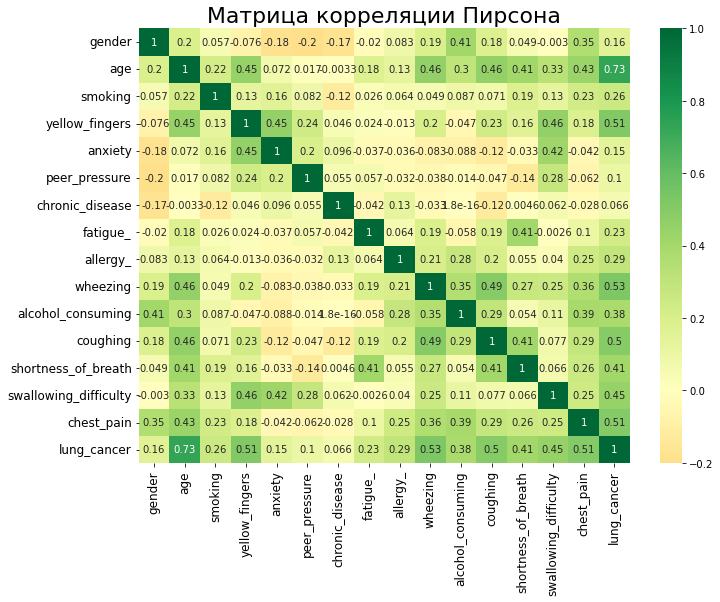

In [6]:
#матрица корреляций Пирсона

plt.figure(figsize=(11, 8))
sns.heatmap(df.corr(),
            xticklabels=df.corr().columns,
            yticklabels=df.corr().columns,
            cmap='RdYlGn', center=0, annot=True)
plt.title('Матрица корреляции Пирсона', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

interval columns not set, guessing: ['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety', 'peer_pressure', 'chronic_disease', 'fatigue_', 'allergy_', 'wheezing', 'alcohol_consuming', 'coughing', 'shortness_of_breath', 'swallowing_difficulty', 'chest_pain', 'lung_cancer']
interval columns not set, guessing: ['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety', 'peer_pressure', 'chronic_disease', 'fatigue_', 'allergy_', 'wheezing', 'alcohol_consuming', 'coughing', 'shortness_of_breath', 'swallowing_difficulty', 'chest_pain', 'lung_cancer']
interval columns not set, guessing: ['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety', 'peer_pressure', 'chronic_disease', 'fatigue_', 'allergy_', 'wheezing', 'alcohol_consuming', 'coughing', 'shortness_of_breath', 'swallowing_difficulty', 'chest_pain', 'lung_cancer']


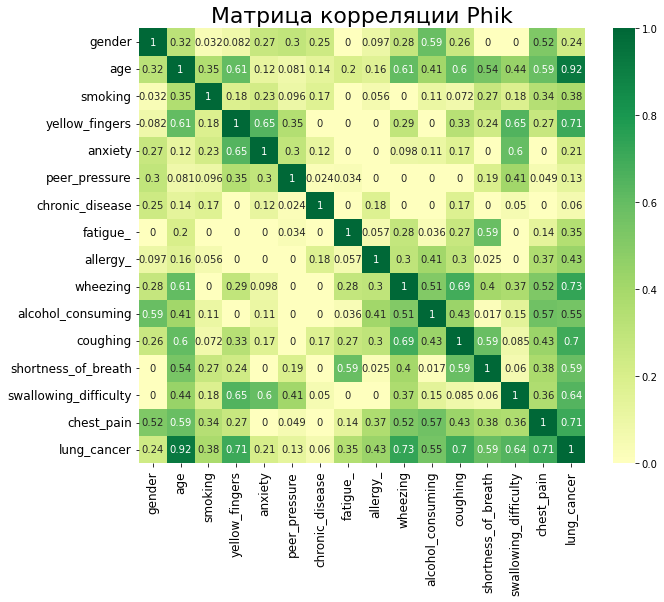

In [7]:
# матрица корреляций по коэффициенту phi

plt.figure(figsize=(10, 8))
sns.heatmap(df.phik_matrix(),
            xticklabels=df.phik_matrix().columns,
            yticklabels=df.phik_matrix().columns,
            cmap='RdYlGn', center=0, annot=True)
plt.title('Матрица корреляции Phik', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show();

Линейные связи между признаками слабые и практически исключают мультиколлинеарность. Коэф-т Пирсона больше чем 0.5 только у пары "anxiety - yellow_fingers" (тревожность - желтые пальцы). \
По нелинейному коэффициенту Phi картина схожая - помимо "anxiety - yellow_fingers" можно с большой натяжкой отметить только пары "anxiety - swallowing_difficulty" и "shortness_of_breath - fatique" (одышка - утомляемость).\
Все признаки оставляю как есть.

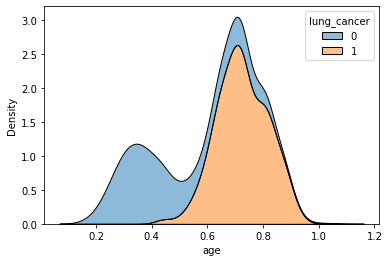

In [8]:
sns.kdeplot(data=df, x='age', hue='lung_cancer', multiple='stack', alpha=.5);

Датасет не репрезентативен по возрасту опрошенных. Есть 2 пика - в районе 30 и 70 лет. Большинство опрошенных с подтвержденным диагнозом имеют возраст больше 50 лет. Возможно, заболевание действительно крайне редко встречается среди молодых людей, но не исключено, что это еще одна особенность конкретного датасета.

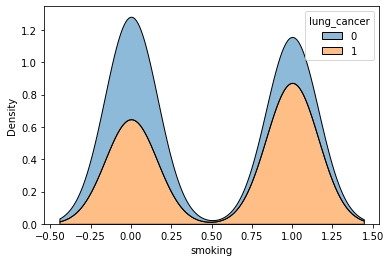

In [9]:
sns.kdeplot(data=df, x='smoking', hue='lung_cancer', multiple='stack', alpha=.5);

Среди курящих значительно больше пациентов с раком легких, чем среди некурящих.

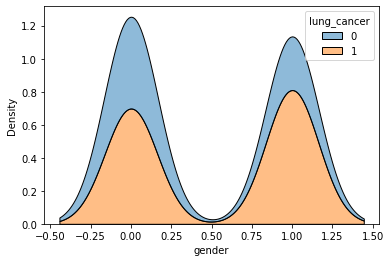

In [10]:
sns.kdeplot(data=df, x='gender', hue='lung_cancer', multiple='stack', alpha=.5);

У мужчин риск развития рака легких выше, чем у женщин.

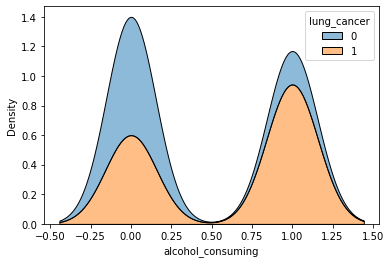

In [11]:
sns.kdeplot(data=df, x='alcohol_consuming', hue='lung_cancer', multiple='stack', alpha=.5);

Среди регулярно употребляющих алкоголь риск развития болезни также выше

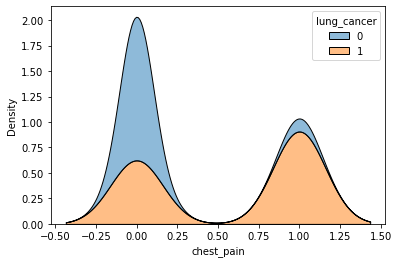

In [12]:
sns.kdeplot(data=df, x='chest_pain', hue='lung_cancer', multiple='stack', alpha=.5);

Судя по этому графику, частые боли в груди - один из важных паттернов заболевания

In [13]:
#копия для альтернативных решений
data = df.copy()

## Разбивка на выборки

In [14]:
train, test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE, stratify=data['lung_cancer'])
train = train.dropna()

features_train = train.drop(['lung_cancer'], axis=1)
target_train = train['lung_cancer']

features_test = test.drop(['lung_cancer'], axis=1)
target_test = test['lung_cancer']

In [15]:
train.shape

(328, 16)

In [16]:
test.shape

(110, 16)

In [17]:
#соотношение 0 к 1 в таргете после разделения
display(round((train.shape[0] - train[train["lung_cancer"] == 0].shape[0]) / train[train["lung_cancer"] == 0].shape[0], 2))
display(round((test.shape[0] - test[test["lung_cancer"] == 0].shape[0]) / test[test["lung_cancer"] == 0].shape[0], 2))

1.6

1.62

Выборки разделены корректно

In [18]:
#функция для вывода параметров модели
def model_report(model, X, y, label=None):
    
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    y_proba_one = y_proba[:, 1]
    
    roc_auc = roc_auc_score(y, y_proba_one)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    
    results.loc[label, 'AUC-ROC'] = roc_auc
    results.loc[label, 'Accuracy'] = accuracy
    results.loc[label, 'Precision'] = precision
    results.loc[label, 'Recall'] = recall
    results.loc[label, 'F1'] = f1
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    
    fpr, tpr, thresholds = roc_curve(y, y_proba_one)
    lw = 2
    axes[0].plot(fpr, tpr, lw=lw, color='grey')
    axes[0].plot([0, 1], [0, 1], color='r')
    axes[0].set_xlim([-0.02, 1])
    axes[0].set_ylim([0.0, 1.02])
    axes[0].set_xlabel('\nFalse Positive Rate')
    axes[0].set_ylabel('True Positive Rate\n')
    axes[0].text(0.6, 0.2,
                'ROC-AUC = {:.2f}\n\nAccuracy = {:.2f}\n\nPrecision = {:.2f}\n\nRecall = {:.2f}\n\nF1 = {:.2f}'
                 .format(roc_auc, accuracy, precision, recall, f1))
    
    cm = confusion_matrix(y, y_pred)
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    pcts = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, pcts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, cmap='Reds', fmt ='', ax=axes[1]) 
    axes[1].set_xlabel('\nPredict')
    axes[1].set_ylabel('True value\n')
    
    plt.tight_layout()
    plt.show()
    
    report = classification_report(
        y, y_pred,
        target_names=['Non-lung_cancer', 'Lung_cancer'], output_dict=True
    )

In [19]:
results = pd.DataFrame(
    [[0] * 5] * 3,
    index=['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'],
    columns=['AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1'])

## LogisticRegression

In [20]:
#подбор параметров модели
paramsLR = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
modelLR = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')

gridLR = GridSearchCV(modelLR, paramsLR, cv=3, scoring='roc_auc')
 
gridLR.fit(features_train, target_train)

score_lr = gridLR.best_score_

print('Лучшие параметры:', gridLR.best_params_)             
print('ROC-AUC:', score_lr)

Лучшие параметры: {'C': 10.0, 'penalty': 'l1'}
ROC-AUC: 0.9788104296444945


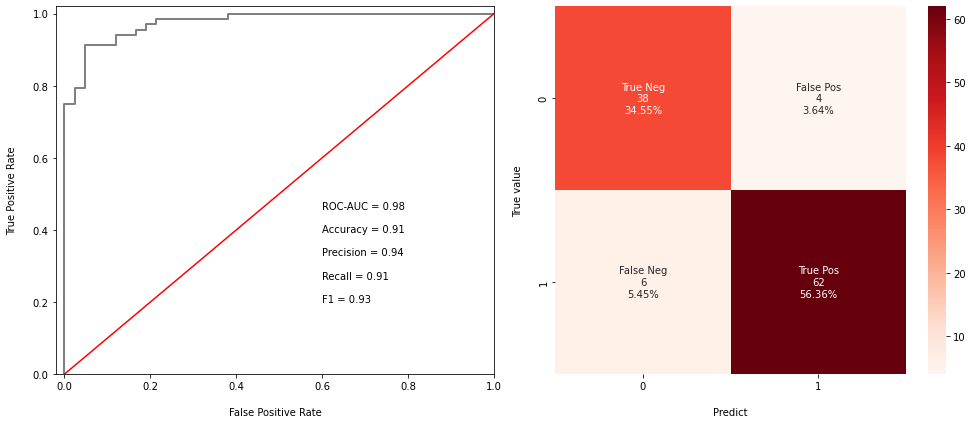

In [21]:
model_lr = LogisticRegression(random_state=RANDOM_STATE, 
                              C=10, penalty='l1', 
                              solver='liblinear', 
                              class_weight='balanced')
model_lr.fit(features_train, target_train)

model_report(model_lr, features_test, target_test, label='LogisticRegression')

## Random Forest

%%time

#подбор оптимальных гиперпараметров

clf = RandomForestClassifier(random_state=RANDOM_STATE)

parametrs = { 'n_estimators': range(10, 51, 10),
              'max_depth': range(1, 13, 2),
              'min_samples_leaf': range(1, 8),
              'min_samples_split': range(2, 10, 2) }

grid = GridSearchCV(clf, parametrs, scoring='roc_auc', cv=3)
grid.fit(features_train, target_train)
grid.best_params_

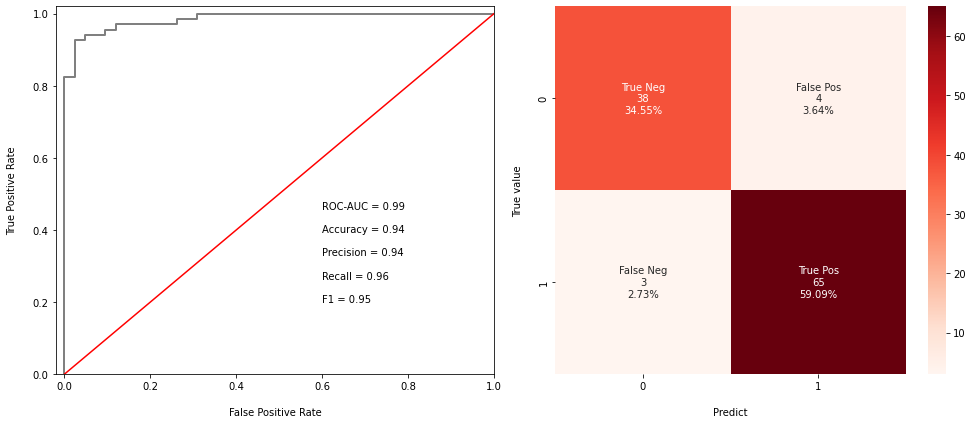

In [22]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE,
                                 n_estimators=500,
                                 max_depth=5,
                                 min_samples_leaf=1,
                                 min_samples_split=2)
model_rf.fit(features_train, target_train)

model_report(model_rf, features_test, target_test, label='RandomForestClassifier')

In [23]:
import pickle

# Сохранение модели в файл
with open('model_rf.pkl', 'wb') as file:
    pickle.dump(model_rf, file)

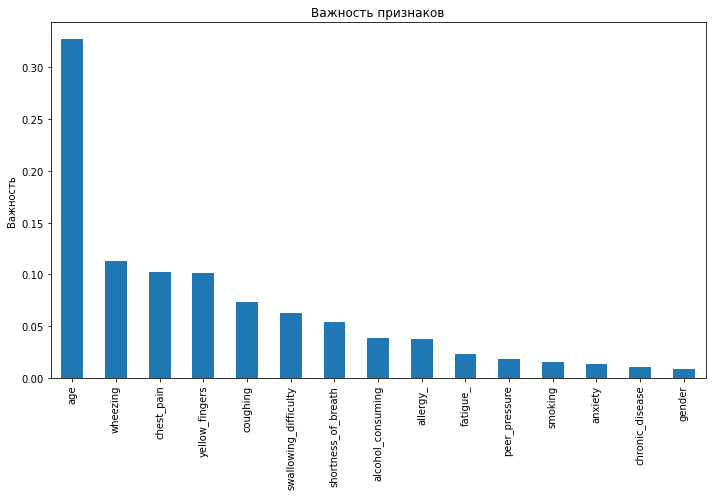

In [24]:
#оценка важности признаков
rf_imp = pd.Series(model_rf.feature_importances_, features_train.columns)
rf_imp = rf_imp.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 7))
rf_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## CatBoost c параметрами по умолчанию

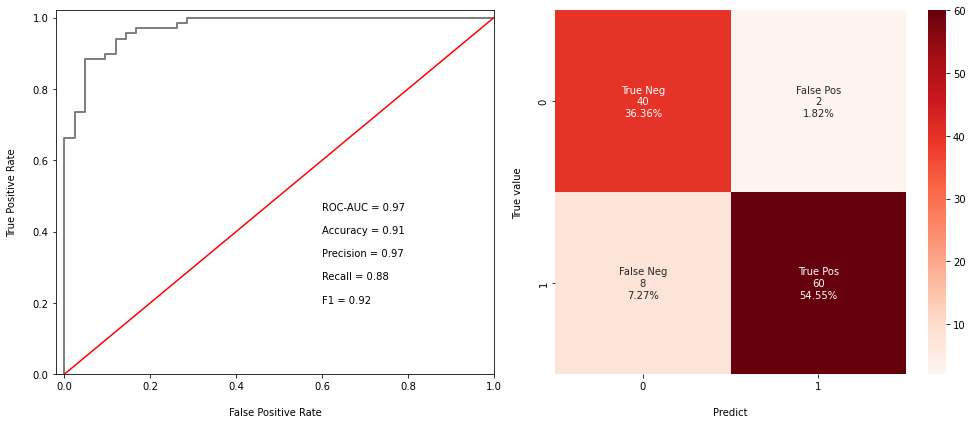

In [25]:
#для эксперимента попробуем катбуст с параметрами по умолчанию
model = CatBoostClassifier(iterations=1000, 
                           loss_function="Logloss", 
                           class_weights = (1.5, 1), 
                           verbose=False,
                           random_state=RANDOM_STATE)
model.fit(features_train, target_train, plot=False)

model_report(model, features_test, target_test, label='CatBoost_default')

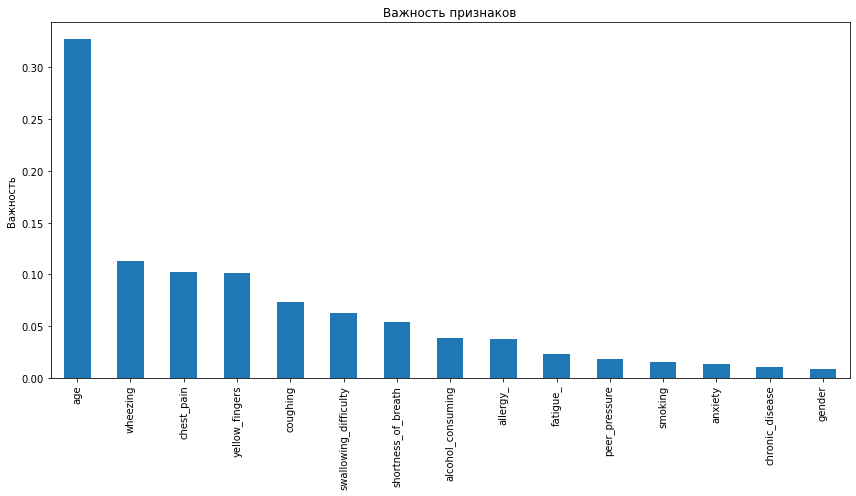

In [26]:
#оценка важности признаков
cb_imp = pd.Series(model.feature_importances_, features_train.columns)
cb_imp = rf_imp.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 7))
cb_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## CatBoost с подбором параметров

param_grid = [{
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': range(1, 11, 2),
    'l2_leaf_reg': range(3, 9, 2),
    'has_time': [True],
    'random_state': [RANDOM_STATE],
}]

model_cb = CatBoostClassifier(iterations=100, loss_function="Logloss", class_weights = (1.5, 1), verbose=False)

grid_search_cb = GridSearchCV(model_cb, param_grid, cv=3, scoring='roc_auc', n_jobs=1)
grid_search_cb.fit(features_train, target_train)

roc_auc_cb = grid_search_cb.best_score_

print(f'roc_auc CatBoost: {roc_auc_cb}') 
print(f'Лучшие гиперпараметры: {grid_search_cb.best_params_}')

In [27]:
model_cb = CatBoostClassifier(iterations=500,
                              depth=5,
                              l2_leaf_reg=5,
                              learning_rate=.1,
                              random_state=RANDOM_STATE,
                              loss_function="Logloss", 
                              class_weights=(1.5, 1), 
                              verbose=False)
model_cb.fit(features_train, target_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

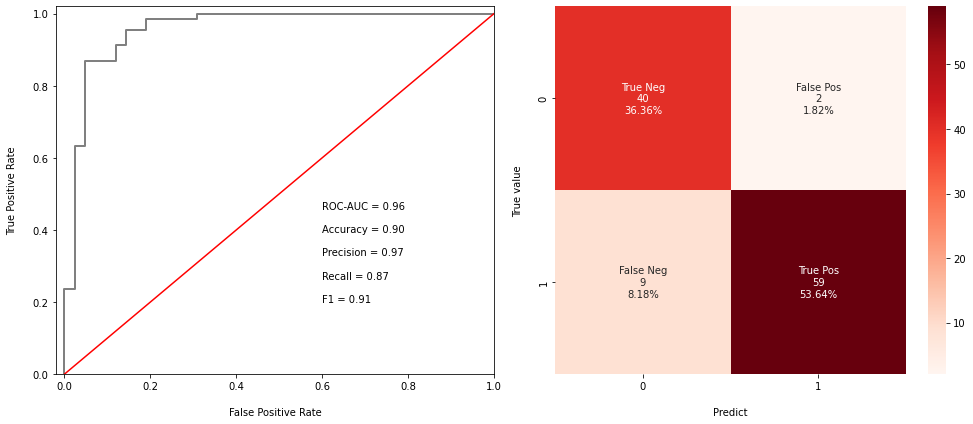

In [28]:
model_report(model_cb, features_test, target_test, label='CatBoostClassifier')

In [29]:
# Получение вероятностей принадлежности к классам
y_pred_proba = model_cb.predict_proba(features_test)

# Изменение порогового значения для оптимизации метрики
threshold = 0.05
y_pred = [1 if prob[1] > threshold else 0 for prob in y_pred_proba]

# Оценка метрик
precision = precision_score(target_test, y_pred)
recall = recall_score(target_test, y_pred)
f1 = f1_score(target_test, y_pred)
accuracy = accuracy_score(target_test, y_pred)

print(precision)
print(recall) # нужен максимальный
print(f1)
print(accuracy)

0.9154929577464789
0.9558823529411765
0.9352517985611511
0.9181818181818182


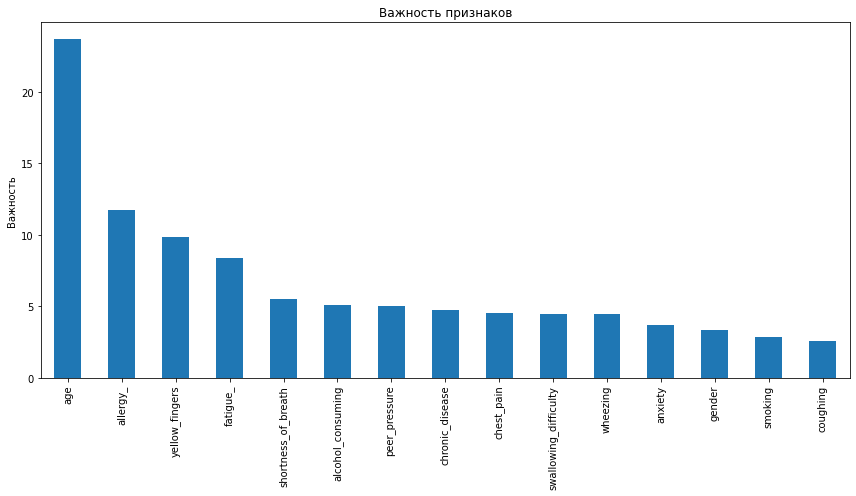

In [30]:
#оценка важности признаков
cbgs_imp = pd.Series(model_cb.feature_importances_, features_train.columns)
cbgs_imp = cbgs_imp.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 7))
cbgs_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

### Проверка критичных признаков

In [31]:
imp_list = rf_imp.index
drop_list = imp_list[-3:] #здесь указываем, сколько признаков с конца нужно дропнуть
drop_list

Index(['anxiety', 'chronic_disease', 'gender'], dtype='object')

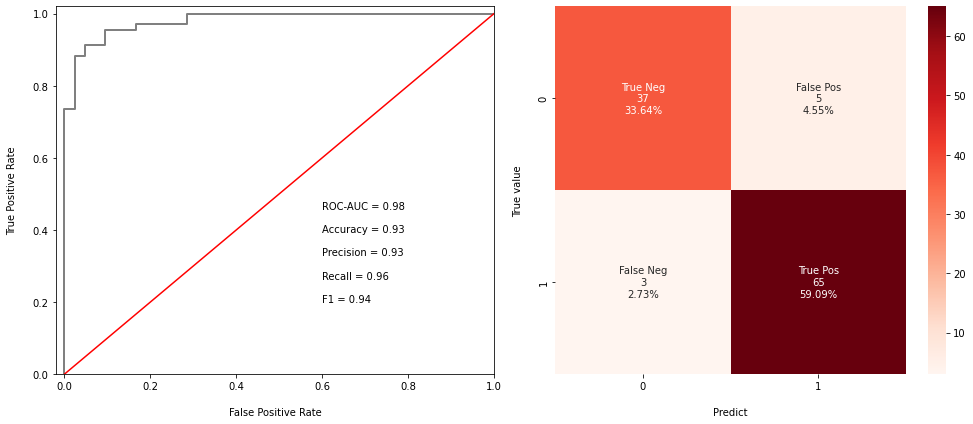

In [32]:
#оставляем только самые важные признаки и на них обучаем, проверяем модель
#f_list = cbgs_imp.index
train_imp = features_train.drop(drop_list, axis=1)
test_imp = features_test.drop(drop_list, axis=1)

model_imp = RandomForestClassifier(random_state=RANDOM_STATE,
                                 n_estimators=500,
                                 max_depth=5,
                                 min_samples_leaf=1,
                                 min_samples_split=2)
model_imp.fit(train_imp, target_train)

model_report(model_imp, test_imp, target_test, label='RF_imp_feat')

imp_list = cbgs_imp.index
drop_list = imp_list[-3:] #здесь указываем, сколько признаков с конца нужно дропнуть
drop_list

#оставляем только самые важные признаки и на них обучаем, проверяем модель
f_list = cbgs_imp.index
train_imp = features_train.drop(drop_list, axis=1)
test_imp = features_test.drop(drop_list, axis=1)

model_imp = CatBoostClassifier(iterations=500,
                              depth=5,
                              l2_leaf_reg=5,
                              learning_rate=.1,
                              random_state=RANDOM_STATE,
                              loss_function="Logloss", 
                              class_weights =(1.5, 1), 
                              verbose=False)
model_imp.fit(train_imp, target_train, plot=False)

model_report(model_imp, test_imp, target_test, label='CB_GS_imp_feat')

## Сравнение моделей

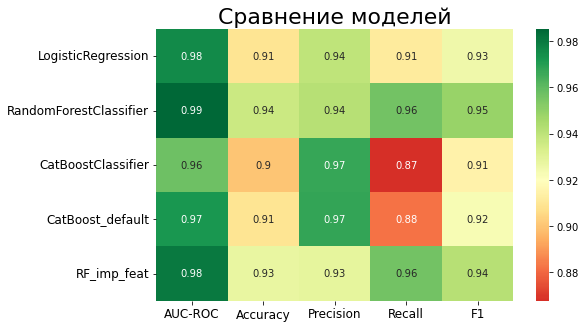

In [33]:
plt.figure(figsize=(8, 5))
sns.heatmap(results,
            xticklabels=results.columns,
            yticklabels=results.index, 
            cmap='RdYlGn', center=0.92, annot=True)
plt.title('Сравнение моделей', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show();

## Проверка модели

In [34]:
features_test.columns

Index(['gender', 'age', 'smoking', 'yellow_fingers', 'anxiety',
       'peer_pressure', 'chronic_disease', 'fatigue_', 'allergy_', 'wheezing',
       'alcohol_consuming', 'coughing', 'shortness_of_breath',
       'swallowing_difficulty', 'chest_pain'],
      dtype='object')

In [35]:
gender=1
age=31 / mx_age_scal
smoking=0
yellow_fingers=0
anxiety=0
peer_pressure=0
chronic_disease=1
fatigue=1
allergy=1
wheezing=0
alcohol_consuming=1
coughing=0
shortness_of_breath=0
swallowing_difficulty=0
chest_pain=0

test_vect = np.array([gender, age, smoking, yellow_fingers, anxiety,
       peer_pressure, chronic_disease, fatigue, allergy, wheezing,
       alcohol_consuming, coughing, shortness_of_breath,
       swallowing_difficulty, chest_pain])
print(f'Вероятное наличие диагноза (1-да, 0-нет): {model_rf.predict(test_vect.reshape(1, -1))[0]}')
print(f'Вероятность рака легких: {model_rf.predict_proba(test_vect.reshape(1, -1))[0, 1]:.1%}')

C:\Users\Xiaomi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Xiaomi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Вероятное наличие диагноза (1-да, 0-нет): 0
Вероятность рака легких: 7.5%


## Вывод

Выборка состоит всего из 309 объектов, большинство из которых (270) имеют подтвержденный диагноз, из-за чего модель скорее всего завышает вероятность наличия диагноза. Для улучшения модели стоит добавить в выборку 200-300 пациентов, преимущественно здоровых.
Если же приоритет стоит на минимизации False Negative, а False Positive не так критична, то текущая модель уже может использоваться в работе.

UPD: после добавления в датасет 129 здоровых людей (результаты опроса) модель работает более адекватно - логических нестыковок меньше, результат вызывает намного больше доверия.

Признаки 'anxiety', 'chronic_disease', 'gender' практически не влияют на результат работы модели, поэтому в непосредственной работе их можно вносить по желанию.